In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from tqdm.auto import tqdm
import numpy as np
import random

import mimic3models.metrics as m
import matplotlib.pyplot as plt
import glob

from DataLoader import LoadDataSets
from lstm_cnn import LSTM_CNN4
from lstm_cnn import trainer, evaluate, calcMetrics, plotLoss, plotAUC

# Set random seeds

In [2]:
#CUDA RNN and LSTM
#In some versions of CUDA, RNNs and LSTM networks may have non-deterministic behavior. See torch.nn.RNN() and torch.nn.LSTM() for details and workarounds.
# https://pytorch.org/docs/stable/notes/randomness.html

def randseed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

randseed()

# Load Training, Test and Validation Data Sets

In [3]:
# if you want to evaluate models with MIMIC-III then sey mimic=False
# if you want to evaluate models with MIMIC-IV then sey mimic=True
mimic4 = True

In [4]:
try:
    del train_data
except:
    pass

try:
    del test_data
except:
    pass

try:
    del val_data
except:
    pass

already_loaded = False

dataloader_train, dataloader_val, dataloader_test = LoadDataSets(batch_size=64,mimic4=mimic4)

Loading train, test and validation data... from ../readmission/train_data_mimic4/
Dimensions Train Data:  21578 48 390
Dimensions:  7076 48 390
Dimensions:  7034 48 390


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Train a specific LSTM+CNN model

In [15]:
randseed()

# define threshold
threshold = 0.5
logit_threshold = torch.tensor (threshold / (1 - threshold)).log()
    
best_accuracy = 0
best_roc_auc = 0
best_loss = 100000

# 128, 4, 0.001, 0.5, 0.3, 0.5) 100 epochs 0.76
# 24, 2, 0.001, 0.5, 0.5, 0.5) 30 epochs 0.76
hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv = (8, 2, 1e-3, 0.3, 0.2, 0.2)
print(hidden_dim, lstm_layers, lr, dropout, dropout_w, dropout_conv)

# 20210323 22:05 16, 2, 1e-3, 0.5, 0.2, 0.5

8 2 0.001 0.3 0.2 0.2


In [18]:
number_epochs = 30

(best_loss, best_accuracy, best_roc_auc), train_loss, val_loss,modelsignature = trainer(dataloader_train, dataloader_val,
                                                                         number_epochs=number_epochs,
                                                                         hidden_dim=hidden_dim,
                                                                         lstm_layers=lstm_layers, lr=lr,
                                                                         dropout=dropout,
                                                                         dropout_w=dropout_w,
                                                                         dropout_conv=dropout_conv,
                                                                         best_loss=best_loss,
                                                                         best_accuracy=best_accuracy,
                                                                         best_roc_auc=best_roc_auc,
                                                                         early_stopping=0,
                                                                         verbatim=True)

##print((best_loss, best_accuracy, best_roc_auc), train_loss, val_loss)

Training Model
Epoch Train: 0, Accuracy Score = 0.6618, Loss = 0.6177
Epoch Val: 0, Accuracy Score = 0.7100 (0.7801), ROCAUC = 0.7497 (0.7655), Loss = 0.5763 (0.4809)
--------------------
Epoch Train: 1, Accuracy Score = 0.6831, Loss = 0.5968
Epoch Val: 1, Accuracy Score = 0.6262 (0.7801), ROCAUC = 0.7539 (0.7655), Loss = 0.6348 (0.4809)
--------------------
Epoch Train: 2, Accuracy Score = 0.6902, Loss = 0.5870
Epoch Val: 2, Accuracy Score = 0.7643 (0.7801), ROCAUC = 0.7577 (0.7655), Loss = 0.5423 (0.4809)
--------------------
Epoch Train: 3, Accuracy Score = 0.6903, Loss = 0.5832
Epoch Val: 3, Accuracy Score = 0.6782 (0.7801), ROCAUC = 0.7576 (0.7655), Loss = 0.6289 (0.4809)
--------------------
Epoch Train: 4, Accuracy Score = 0.6935, Loss = 0.5803
Epoch Val: 4, Accuracy Score = 0.6208 (0.7801), ROCAUC = 0.7617 (0.7655), Loss = 0.6259 (0.4809)
--------------------
Epoch Train: 5, Accuracy Score = 0.6983, Loss = 0.5723
Epoch Val: 5, Accuracy Score = 0.7427 (0.7801), ROCAUC = 0.7617 (

In [11]:
print("Results on Test Data Set:")
print(f"Best loss={best_loss}, best accuracy={best_accuracy}, and best AUC={best_roc_auc}")

filename_loss = glob.glob(f"*{modelsignature}*loss-{best_loss}*.pth")[0]
filename_acc = glob.glob(f"*{modelsignature}*acc-{best_accuracy}*.pth")[0]
filename_auc = glob.glob(f"*{modelsignature}*auc-{best_roc_auc}.pth")[0]

print()
print("Files with the best values when evaluated against the test data set:")
print(filename_loss)
print(filename_acc)
print(filename_auc)

Results on Test Data Set:
Best loss=0.5806959271430969, best accuracy=0.7036461277557943, and best AUC=0.7540872369094317

Files with the best values when evaluated against the test data set:
model__1000_128_2_1e-06_0.5-0.2-0.3__epoch-51_loss-0.5806959271430969_acc-0.7036461277557943_auc-0.7500674876167471.pth
model__1000_128_2_1e-06_0.5-0.2-0.3__epoch-51_loss-0.5806959271430969_acc-0.7036461277557943_auc-0.7500674876167471.pth
model__1000_128_2_1e-06_0.5-0.2-0.3__epoch-111_loss-0.5829753875732422_acc-0.6996890898812889_auc-0.7540872369094317.pth


# Evaluate best modell

In [12]:
model = LSTM_CNN4(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dropout=0.5, dropout_w=0.5, dropout_conv=0.5)
model.to(device)

calcMetrics(model, dataloader_test, filename_loss, "Test Loss")
calcMetrics(model, dataloader_test, filename_acc, "Test Accuracy")
roc_auc, targets, outputs = calcMetrics(model, dataloader_test, filename_auc, "Test AUC")


Test Loss


/system/apps/userenv/students/plasser/ICU_Readmission_Analysis_Pytorch_gpu/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79      5716
         1.0       0.35      0.67      0.46      1318

    accuracy                           0.70      7034
   macro avg       0.63      0.69      0.63      7034
weighted avg       0.80      0.70      0.73      7034

Accuracy Score = 0.7004549331816889, Loss = 0.5804665684700012
--------------------
confusion matrix:
[[4822  894]
 [ 674  644]]
accuracy = 0.77708274
precision class 0 = 0.87736535
precision class 1 = 0.4187256
recall class 0 = 0.84359694
recall class 1 = 0.48861912
AUC of ROC = 0.7511544146771144
AUC of PRC = 0.41698066475552037
ROC AUC =  0.7511544146771144

Test Accuracy
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79      5716
         1.0       0.35      0.67      0.46      1318

    accuracy                           0.70      7034
   macro avg       0.63      0.69      0.63      7034
weighted avg       0.80

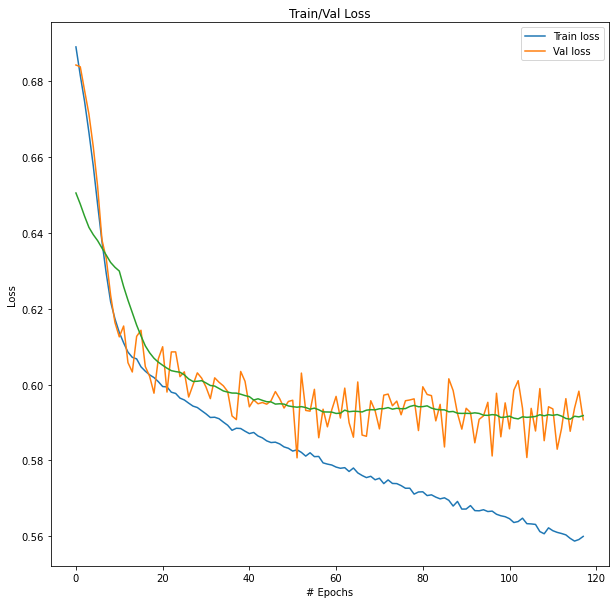

In [13]:
plotLoss(train_loss, val_loss)

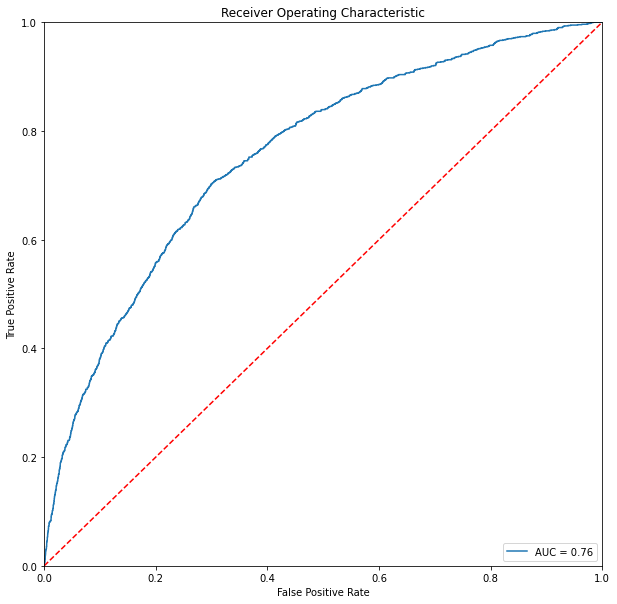

In [14]:
plotAUC(targets, outputs)